In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

C:\Users\Basel\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df=pd.read_csv(r"C:\Users\Basel\Desktop\Mr Taha\Wind_Time_Series_Dataset\Wind Time Series Dataset(hourly).csv",index_col=[0])

In [3]:
df.isnull().sum()

WindSpeed    0
Power        0
dtype: int64

In [4]:
df.head()

,WindSpeed,Power
Time,,
2014-10-07 02:00:00,7.567500,29.605953
2014-10-07 03:00:00,5.921667,12.383663
2014-10-07 04:00:00,6.256667,14.702530
2014-10-07 05:00:00,6.238333,15.391273
2014-10-07 06:00:00,6.951667,23.176807


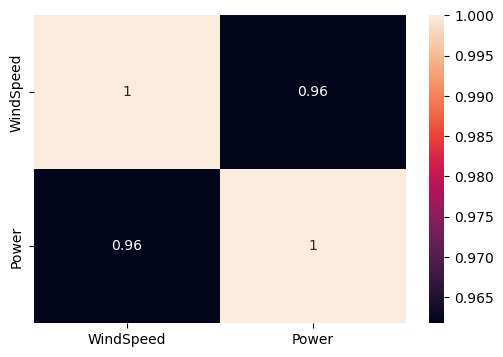

In [5]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [6]:
df.index.min()

'2014-10-07 02:00:00'

In [7]:
df.index.max()

'2015-10-07 00:00:00'

In [8]:
df_train=df[:'2015-10-01 00:00:00']

In [9]:
df_test=df['2015-10-01 00:00:00':]

In [10]:
df.columns

Index(['WindSpeed', 'Power'], dtype='object')

In [11]:
df_train=df[:'2015-10-01 00:00:00']

In [12]:
df_test=df['2015-10-01 00:00:00':]

In [13]:
len(df_train)

7139

In [14]:
len(df_test)

126

In [15]:
len(df)

7265

In [25]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['WindSpeed', 'Power']])

In [26]:
def create_windows(data, window_size, target_col_index):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, target_col_index])
    return np.array(X), np.array(y)

window_size = 24
target_index = 1 
X, y = create_windows(scaled_data, window_size, target_index)

print(X.shape, y.shape)

(7241, 24, 2) (7241,)


In [27]:
train_size = int(7139-24)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [33]:
model = Sequential()
model.add(LSTM(32, 
               return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [34]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
201/201 [==============================] - 14s 34ms/step - loss: 0.0461 - val_loss: 0.0239
Epoch 2/20
201/201 [==============================] - 5s 26ms/step - loss: 0.0287 - val_loss: 0.0161
Epoch 3/20
201/201 [==============================] - 5s 23ms/step - loss: 0.0207 - val_loss: 0.0169
Epoch 4/20
201/201 [==============================] - 5s 25ms/step - loss: 0.0184 - val_loss: 0.0125
Epoch 5/20
201/201 [==============================] - 5s 27ms/step - loss: 0.0182 - val_loss: 0.0133
Epoch 6/20
201/201 [==============================] - 6s 29ms/step - loss: 0.0181 - val_loss: 0.0124
Epoch 7/20
201/201 [==============================] - 7s 36ms/step - loss: 0.0180 - val_loss: 0.0125
Epoch 8/20
201/201 [==============================] - 7s 35ms/step - loss: 0.0181 - val_loss: 0.0136
Epoch 9/20
201/201 [==============================] - 7s 35ms/step - loss: 0.0180 - val_loss: 0.0123
Epoch 10/20
201/201 [==============================] - 6s 28ms/step - loss: 0.0179 - val_l

In [35]:
y_pred = model.predict(X_test)

y_test_scaled = np.zeros((len(y_test), 2))
y_test_scaled[:, target_index] = y_test
y_test_inverse = scaler.inverse_transform(y_test_scaled)[:, target_index]

y_pred_scaled = np.zeros((len(y_pred), 2))
y_pred_scaled[:, target_index] = y_pred[:,0]
y_pred_inverse = scaler.inverse_transform(y_pred_scaled)[:, target_index]

4/4 [==============================] - 3s 11ms/step


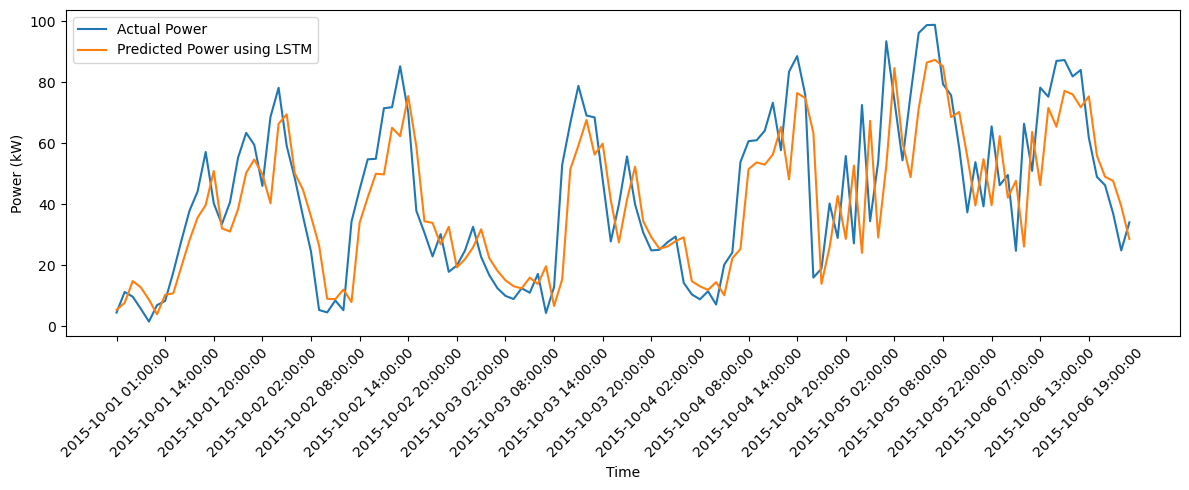

In [36]:
import matplotlib.pyplot as plt

tick_indices = range(0, len(df_test.index), 6)
tick_labels = df_test.index[tick_indices]

plt.figure(figsize=(12,5))
plt.plot(df_test.index, y_test_inverse, label='Actual Power')
plt.plot(df_test.index, y_pred_inverse, label='Predicted Power using LSTM')

plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.xticks(tick_indices, tick_labels, rotation=45)  # set every 4th tick
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print("MAE:", np.round(mae,2))
print("MSE:", np.round(mse,2))
print("RMSE:", np.round(rmse,2))
print("R²:", np.round(r2*100,2),"%")

MAE: 12.11
MSE: 247.74
RMSE: 15.74
R²: 63.38 %


In [42]:
df=pd.DataFrame(data={'Actual':y_test_inverse,'LSTM':y_pred_inverse})

In [45]:
df.to_csv(r'C:\Users\Basel\Desktop\Mr Taha\Wind_Time_Series_Dataset\LSTM Prediction.csv')

#### 